**AdaBoost композиция классификаторов** 

Евгений Борисов  <esborisov@sevsu.ru>

MachineLearning.ru : Алгоритм_AdaBoost   
http://www.machinelearning.ru/wiki/index.php?title=Алгоритм_AdaBoost

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# генерируем данные

(1024, 2)

(1024, 1)

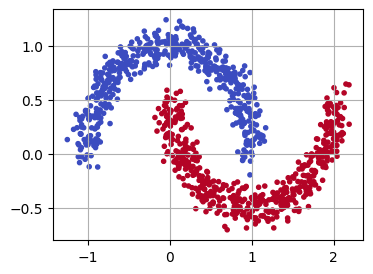

In [2]:
from sklearn.datasets import make_moons
X,target = make_moons(n_samples=1024, noise=.09)

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=1024, centers=2,  cluster_std=[1.5, 1.8,] )

target = (2*target-1).reshape(-1,1)
display(X.shape, target.shape)

fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [3]:
# target

In [4]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

# display( X.min(),np.mean(X),np.median(X),X.max() 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(512, 2)

(512, 2)

# модель

## базовая модель

линейный классификатор

$$a(x,w) = sign \left( \sum\limits_{i=1} x_i \cdot w_i + w_0 \right) $$ 

In [6]:
class LinearClassifier:
    
    def __init__( self, weight=np.array([]) ):
        self._weight = weight
    
    def score(self,x):
        assert len(x)>0
        assert x.shape[1]==len(self._weight)
        return x.dot(self._weight)
    
    def predict(self,x): 
        return np.sign( self.score(x) ).astype(np.int8)
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
        
    def weight_init(self,n,scale=1e-7): 
        self._weight = rng.normal(size=(n,1),scale=scale)
        return self
   
    def score_partial(self,x): # частные производные модели по её параметрам
        return x

In [7]:
from sklearn.preprocessing import PolynomialFeatures

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures( degree=1, interaction_only=False, include_bias=True,).fit(X_train)
# poly.transform(X_train)

In [8]:
# LinearClassifier( weight=rng.rand(X_train.shape[1]+1,1) ).score(poly.transform(X_train))
# LinearClassifier( weight=rng.rand(X_train.shape[1]+1,1) ).predict(poly.transform(X_train))

### обучаем базовую модель

отступ (margin) показывает насколько далеко объект $x$ от разделяющей поверхности

$$
M( x,y ; w )= y \cdot \langle x,w \rangle
$$

функция потери

$$ L = \log \left( 1 + \exp(-M) \right) $$

$$ \nabla L = - \frac{1}{1+\exp(-M)} $$

In [9]:
class LogLoss:

    def score(self,target,predicted): 
        return np.log( 1 + np.exp( - self._margin(target,predicted) ) ).mean()
    
    def _margin(self,target,predicted): 
        return target*predicted
    
    def partial( self, target, predicted, model_partial): # градиент функции потери
        margin = self._margin(target,predicted)
        dl = -1./( np.exp( -margin )+1 )
        g = model_partial.T.dot( target*dl )
        g /= np.abs(g).max() # нормируем градиент
        return g

In [10]:
# model =  LinearClassifier( weight=rng.rand(X_train.shape[1]+1,1) )
# s = model.score( poly.transform(X_train) )
# p = model.score_partial( poly.transform(X_train) )
# LogLoss().partial(target_train,s,p)

In [11]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

class TrainGD:
    
    def __init__(self,model,loss):
        self._model = model
        self._loss = loss   
        self._lr = .1     
       
    def fit( self, X, target, lr=1e-2, n_epoch=512, acc_min=.99, ): 
        # n_epoch - максимальное число циклов обучения
        # acc_min - порог минимально допустимой погрешности модели
        self._lr = lr   # скорость обучения
        n_param = X.shape[1] # размер вектора признаков

        # инициализация параметров модели
        self._model.weight_init(n_param)
        # начальное значение ф-ции потери
        acc_history = [ accuracy_score(target,self._model.predict(X)) ]
        #for i in tqdm(range(n_epoch)): # цикл обучения
        for i in range(n_epoch): # цикл обучения
            self._fit_epoch(X,target) # корректируем веса модели
            acc_history.append( accuracy_score(target,self._model.predict(X)) )
            # проверяем достижение минимального порога погрешности модели
            if acc_history[-1] > acc_min: break
        return acc_history, self._model
    
    @property
    def model(self): return self._model
    
    def _fit_epoch(self,X,target):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X) ) 
        self._weight_adjust(g) # корректируем параметры    
        return self
        
    def _weight_adjust(self,g):
        self._model.weight = self._model.weight - self._lr*g   # корректируем параметры
        return self
        

---

In [12]:
_,model = TrainGD( model=LinearClassifier(), loss=LogLoss() ).fit(poly.transform(X_train),target_train)

              precision    recall  f1-score   support

          -1       0.97      0.53      0.69       260
           1       0.67      0.98      0.80       252

    accuracy                           0.76       512
   macro avg       0.82      0.76      0.74       512
weighted avg       0.82      0.76      0.74       512



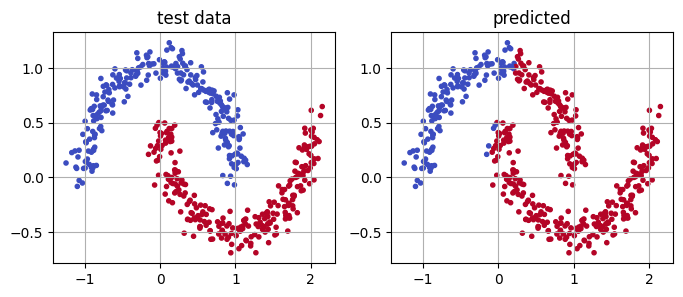

In [13]:
from sklearn.metrics import classification_report

predicted = model.predict(poly.transform(X_test))

print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

## композиция моделей

взвешенное голосование 

$$
a(x) = sign \left( \sum_{i=1}^T w_i \cdot b_i(x) \right)
$$

In [14]:
class WeigtedVotingEnsembleClassifier:
    
    def __init__( self,weight=[],models=[]):
        assert len(weight)==len(models)
        self._weight = weight
        self._models = models
            
    def score(self,x):
        assert len(x)>0
        assert len(self._models)>0
        assert len(self._weight)==len(self._models)
        return np.hstack([ 
                w*b.predict(x) for w,b in zip(self._weight,self._models) 
            ]).sum(axis=-1,keepdims=True)
    
    def predict(self,x): 
        return np.sign( self.score(x) ).astype(np.int8)  
   
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
        
    @property
    def models(self): return self._models

    @models.setter
    def models(self,value): self._base = value
     
    def append(self,model,weight):
        self._weight.append(weight)
        self._models.append(model)
        return self
    
    # def __del__(self): del self._models

In [15]:
# WeigtedVotingEnsembleClassifier(
#         models=[DecisionStumbClassifier(),DecisionStumbClassifier()],
#         weight=[.7,.3],
#     ).predict(X_train)

## обучение композиции

каждому учебному примеру присваиваем вес - вероятность ошибки на примере

In [16]:
# class LogLoss:

#     def score(self,target,predicted): 
#         return np.log( 1 + np.exp( - self._margin(target,predicted) ) ).mean()
    
#     def _margin(self,target,predicted): 
#         return target*predicted
    
#     def partial( self, target, predicted, model_partial): # градиент функции потери
#         margin = self._margin(target,predicted)
#         dl = -1./( np.exp( -margin )+1 )
#         g = model_partial.T.dot( target*dl )
#         g /= np.abs(g).max() # нормируем градиент
#         return g

In [17]:
class WeigtedLogLoss(LogLoss):
    
    def __init__(self):
        super().__init__()
        self._xweight=1.
        
    def score(self,target,predicted,xweight): 
        self._xweight=xweight
        return super().score(target,predicted)
    
    def _margin(self,target,predicted): 
        return target*predicted*self._xweight
    
#     def partial(self, target, predicted, model_partial,xweight): # градиент функции потери
#         self._xweight=xweight
#         return super().partial(target, predicted, model_partial)
    
    def partial( self, target, predicted, model_partial,xweight): # градиент функции потери
        self._xweight = xweight
        margin = self._margin(target,predicted)
        dl = -1./( np.exp( -margin )+1 )
        g = model_partial.T.dot( target*dl*self._xweight )
        g /= np.abs(g).max() # нормируем градиент
        return g

In [18]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

class WeigtedTrainGD(TrainGD):
    
    def __init__(self,model,loss, lr=1e-5, n_epoch=64, acc_min=.99,):
        super().__init__(model,loss)
        self._xweight = .1     
        self._lr = lr     
        self._n_epoch=n_epoch
        self._acc_min=acc_min
       
    def fit( self, X, xweight, target): 
        self._xweight = xweight
        return super().fit(X,target,lr=self._lr, n_epoch=self._n_epoch, acc_min=self._acc_min )
    
    def _fit_epoch(self,X,target):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X), self._xweight ) 
        self._weight_adjust(g) # корректируем параметры    
        return self

In [19]:
# #xweight = np.ones(shape=target_train.shape)
# xweight = rng.rand(*target_train.shape)
# xweight = xweight/xweight.sum()

# _,model = WeigtedTrainGD( 
#         model=LinearClassifier(), 
#         loss=WeigtedLogLoss() 
#     ).fit(poly.transform(X_train),xweight,target_train)

# from sklearn.metrics import classification_report

# predicted = model.predict(poly.transform(X_test))

# print(classification_report( target_test, predicted) )

# fig,ax = plt.subplots(1,2, figsize=(8,3),)
# ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
# ax[0].set_title('test data')
# ax[0].grid()
# ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
# ax[1].set_title('predicted')
# ax[1].grid()

----

In [20]:
from sklearn.metrics import accuracy_score
#accuracy_score(y_true, y_pred,)
from copy import deepcopy

In [21]:
class TrainAdaBoost:
    
    def __init__(self,ensemble, base_train ):
        self._ensemble = ensemble
        self._base_train = base_train

    def fit(self,X,target,n_epoch=128,acc_min=.99):
        assert len(X)>1
        assert len(X)==len(target)
        assert len(X.shape)==2
        assert len(target.shape)==2
        assert target.shape[1]==1
        
        # начальные веса примеров, на старте  ошибки равновероятны для всех примеров
        xweight = np.ones(shape=target.shape)
        xweight = xweight/xweight.sum()

        # добавка для расчёта веса компоненты на случай отсутствия ошибок 
        # чтобы знаменатель не обращался в нуль
        d = 1./len(target) 
        
        acc_history = [0.]
        loss_history = [1.]
        
        for jj in tqdm(range(n_epoch)):
            _,model = self._base_train.fit(X,xweight,target)

            o = model.predict(X)

            p = ((o*target>0)*xweight).sum() # сумма весов правильных ответов
            n = ((o*target<0)*xweight).sum() # сумма весов ошибочных ответов

            # print(n,p)
            
            # базовый классификатор должен выдавать результат лучше чем случайный выбор 
            if( n > .5 ): break
                
            a = np.log((p+d)/(n+d)) # вычисляем вес классификатора
            
            # добавляем классификатор в композицию
            self._ensemble.append(deepcopy(model),a)
            
            # обновляем веса объектов
            xweight = xweight * np.exp( -a*target*o )
            xweight = xweight/xweight.sum()

            p = self._ensemble.predict(X)
            acc_history.append( accuracy_score( target, p) ) # значение погрешности композиции
            loss_history.append( self._loss(target,p) ) # значение погрешности композиции
            
            # проверяем достижение минимального порога погрешности модели
            if acc_history[-1] > acc_min: break
        
        return (acc_history,loss_history), self._ensemble
    
    # значение ф-ции потери для композиции классификаторов
    def _loss(self,target,predicted): 
        return np.exp( -target * predicted ).sum()/len(target)

In [22]:
# del model

In [47]:
model = WeigtedVotingEnsembleClassifier()

(acc_history,loss_history),model = TrainAdaBoost(
         ensemble=model,
         base_train=WeigtedTrainGD(
             model=LinearClassifier(),
             loss=WeigtedLogLoss(),
             lr=1e-1,
             n_epoch=2,
             acc_min=.8
         )
     ).fit(poly.transform(X_train),target_train,n_epoch=1024*7)

  0%|          | 0/7168 [00:00<?, ?it/s]

In [48]:
display(len(model.models) )
display(model.weight) 

42

[1.408,
 0.556,
 0.512,
 0.443,
 0.337,
 0.181,
 1.408,
 0.556,
 0.512,
 0.443,
 0.337,
 0.181,
 1.408,
 0.556,
 0.512,
 0.441,
 0.333,
 0.173,
 1.408,
 0.556,
 0.512,
 0.441,
 0.333,
 0.173,
 1.408,
 0.556,
 0.512,
 0.441,
 0.333,
 0.173,
 1.408,
 0.556,
 0.512,
 0.441,
 0.333,
 0.173,
 1.408,
 0.556,
 0.512,
 0.441,
 0.333,
 0.173]

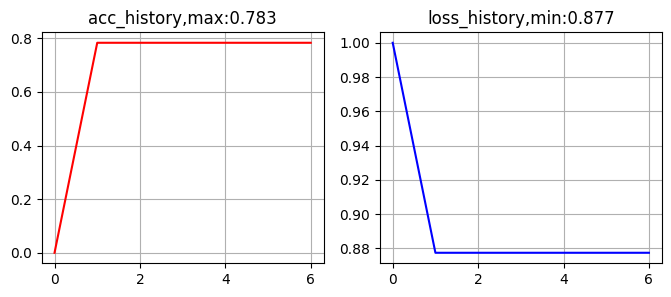

In [49]:
fig,ax = plt.subplots(ncols=2, figsize=(8,3),)
ax[0].plot(acc_history,c='r')
ax[0].set_title(f'acc_history,max:{max(acc_history):.3f}')
ax[0].grid()
ax[1].plot(loss_history,c='b')
ax[1].set_title(f'loss_history,min:{min(loss_history):.3f}')
ax[1].grid()

# тестируем

              precision    recall  f1-score   support

          -1       0.83      0.61      0.71       260
           1       0.69      0.87      0.77       252

    accuracy                           0.74       512
   macro avg       0.76      0.74      0.74       512
weighted avg       0.76      0.74      0.74       512



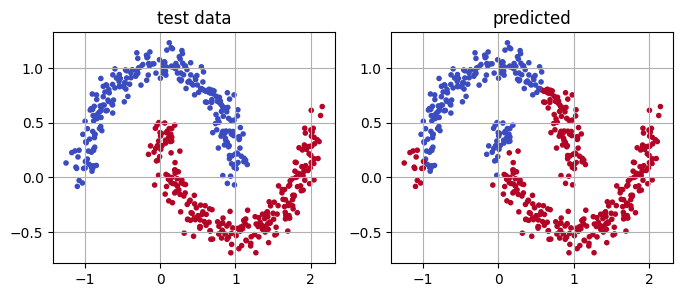

In [50]:
from sklearn.metrics import classification_report

predicted = model.predict( poly.transform(X_test) )

print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

## карта скоров

In [51]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

In [52]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.score( poly.transform(xy) )
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

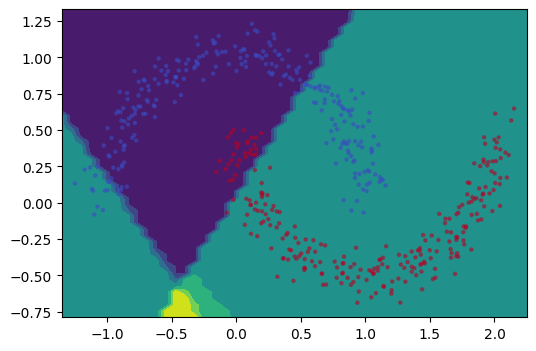

In [53]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

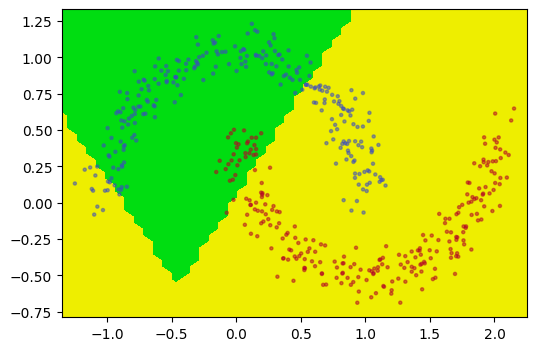

In [54]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict( poly.transform(xy) ).reshape(n,n) 

fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )